In [1]:
import numpy as np
import json
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# Directories
CE_DATA_DIR = Path('./ce_data')
MACE_DIR = Path('./mace_energies')
COMPARISON_DIR = Path('./comparison_results')
COMPARISON_DIR.mkdir(exist_ok=True)

In [2]:
def load_ce_results(ce_dir):
    """Load cluster expansion results from a directory."""
    ce_dir = Path(ce_dir)
    results = {'path': str(ce_dir)}

    # Load fitting stats
    stats_file = ce_dir / 'fitting_stats.json'
    with open(stats_file, 'r') as f:
        results['stats'] = json.load(f)

    # Load ECIs
    eci_file = ce_dir / 'ecis_L1.npy'
    results['ecis'] = np.load(eci_file)

    # Load subspace
    subspace_file = ce_dir / 'subspace.pkl'
    with open(subspace_file, 'rb') as f:
        results['subspace'] = pickle.load(f)

    # Load train data
    train_file = ce_dir / 'ce_data.npz'
    train_data = np.load(train_file)
    results['train_data'] = {
        'feature_matrix': train_data['feature_matrix'],
        'energies': train_data['energies'],
        'n_atoms': train_data['n_atoms'],
        'n_real_atoms': train_data['n_real_atoms']
    }
    print(f"Loaded train data: {len(train_data['energies'])} structures")

    # Load test data
    test_file = ce_dir / 'test_ce_data.npz'
    test_data = np.load(test_file)
    results['test_data'] = {
        'feature_matrix': test_data['feature_matrix'],
        'energies': test_data['energies'],
        'n_atoms': test_data['n_atoms'],
        'n_real_atoms': test_data['n_real_atoms']
    }
    print(f"Loaded test data: {len(test_data['energies'])} structures")

    return results


# Load current results
results_list = load_ce_results(CE_DATA_DIR)

/home/mengyi/anaconda3/envs/torchsim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded train data: 7628 structures
Loaded test data: 1906 structures


In [3]:
# Compute predictions for train and test data
# Train predictions
train_data = results_list['train_data']
train_pred = train_data['feature_matrix'] @ results_list['ecis']
train_true = train_data['energies']
train_residuals = train_pred - train_true
train_abs_errors = np.abs(train_residuals)
train_rel_errors = np.abs(train_residuals / train_true) * 100  # percentage

# Per-atom errors (using real atoms, excluding vacancies)
n_real_atoms_train = train_data['n_real_atoms']
train_residuals_per_atom = train_residuals / n_real_atoms_train

results_list['train_predictions'] = {
    'energies_true': train_true,
    'energies_pred': train_pred,
    'residuals': train_residuals,
    'abs_errors': train_abs_errors,
    'rel_errors': train_rel_errors,
    'residuals_per_atom': train_residuals_per_atom
}

results_list['train_metrics'] = {
    'rmse': np.sqrt(np.mean(train_residuals**2)),
    'mae': np.mean(np.abs(train_residuals)),
    'max_error': np.max(np.abs(train_residuals)),
    'r2': 1 - np.sum(train_residuals**2) / np.sum((train_true - train_true.mean())**2),
    'mean_abs_error_eV': np.mean(train_abs_errors),
    'mean_rel_error_percent': np.mean(train_rel_errors),
    # Per-atom metrics
    'rmse_per_atom': np.sqrt(np.mean(train_residuals_per_atom**2)),
    'mae_per_atom': np.mean(np.abs(train_residuals_per_atom)),
    'max_error_per_atom': np.max(np.abs(train_residuals_per_atom))
}

# Test predictions
test_data = results_list['test_data']
test_pred = test_data['feature_matrix'] @ results_list['ecis']
test_true = test_data['energies']
test_residuals = test_pred - test_true
test_abs_errors = np.abs(test_residuals)
test_rel_errors = np.abs(test_residuals / test_true) * 100  # percentage

# Per-atom errors (using real atoms, excluding vacancies)
n_real_atoms_test = test_data['n_real_atoms']
test_residuals_per_atom = test_residuals / n_real_atoms_test

results_list['test_predictions'] = {
    'energies_true': test_true,
    'energies_pred': test_pred,
    'residuals': test_residuals,
    'abs_errors': test_abs_errors,
    'rel_errors': test_rel_errors,
    'residuals_per_atom': test_residuals_per_atom
}

results_list['test_metrics'] = {
    'rmse': np.sqrt(np.mean(test_residuals**2)),
    'mae': np.mean(np.abs(test_residuals)),
    'max_error': np.max(np.abs(test_residuals)),
    'r2': 1 - np.sum(test_residuals**2) / np.sum((test_true - test_true.mean())**2),
    'mean_abs_error_eV': np.mean(test_abs_errors),
    'mean_rel_error_percent': np.mean(test_rel_errors),
    # Per-atom metrics
    'rmse_per_atom': np.sqrt(np.mean(test_residuals_per_atom**2)),
    'mae_per_atom': np.mean(np.abs(test_residuals_per_atom)),
    'max_error_per_atom': np.max(np.abs(test_residuals_per_atom))
}


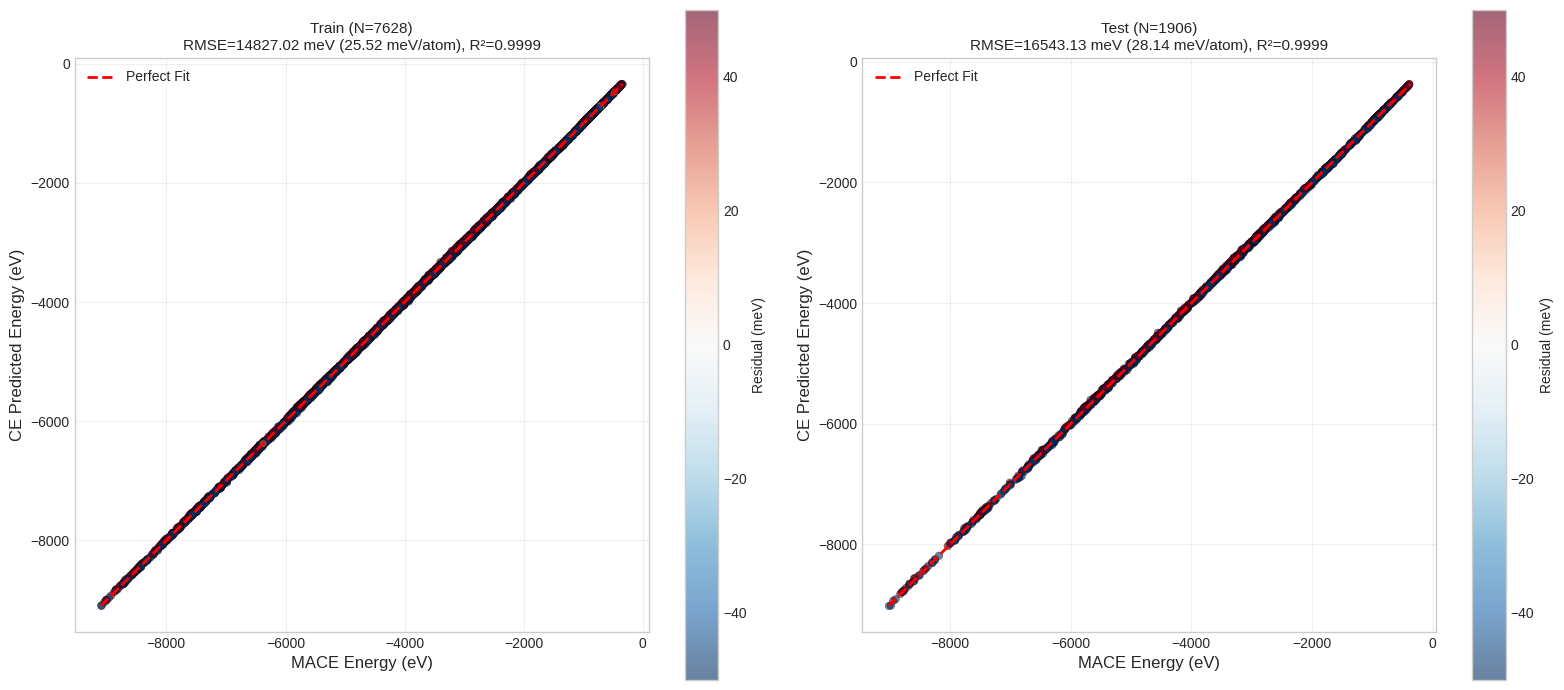


Saved: comparison_results/mace_vs_ce_train_test.png


In [4]:

# Plot Train vs Test
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Train plot
ax = axes[0]
train_preds = results_list['train_predictions']
E_true = train_preds['energies_true']
E_pred = train_preds['energies_pred']
residuals = train_preds['residuals']

scatter = ax.scatter(E_true, E_pred, alpha=0.6, s=30,
                   c=residuals*1000, cmap='RdBu_r', vmin=-50, vmax=50,
                   edgecolors='black', linewidth=0.3)

E_min, E_max = min(E_true.min(), E_pred.min()), max(E_true.max(), E_pred.max())
ax.plot([E_min, E_max], [E_min, E_max], 'r--', lw=2, label='Perfect Fit')

m = results_list['train_metrics']
ax.set_xlabel('MACE Energy (eV)', fontsize=12)
ax.set_ylabel('CE Predicted Energy (eV)', fontsize=12)
ax.set_title(f"Train (N={len(E_true)})\nRMSE={m['rmse']*1000:.2f} meV ({m['rmse_per_atom']*1000:.2f} meV/atom), R²={m['r2']:.4f}", 
            fontsize=11)

plt.colorbar(scatter, ax=ax, label='Residual (meV)')
ax.legend()
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

# Test plot
ax = axes[1]
test_preds = results_list['test_predictions']
E_true = test_preds['energies_true']
E_pred = test_preds['energies_pred']
residuals = test_preds['residuals']

scatter = ax.scatter(E_true, E_pred, alpha=0.6, s=30,
                   c=residuals*1000, cmap='RdBu_r', vmin=-50, vmax=50,
                   edgecolors='black', linewidth=0.3)

E_min, E_max = min(E_true.min(), E_pred.min()), max(E_true.max(), E_pred.max())
ax.plot([E_min, E_max], [E_min, E_max], 'r--', lw=2, label='Perfect Fit')

m = results_list['test_metrics']
ax.set_xlabel('MACE Energy (eV)', fontsize=12)
ax.set_ylabel('CE Predicted Energy (eV)', fontsize=12)
ax.set_title(f"Test (N={len(E_true)})\nRMSE={m['rmse']*1000:.2f} meV ({m['rmse_per_atom']*1000:.2f} meV/atom), R²={m['r2']:.4f}", 
            fontsize=11)

plt.colorbar(scatter, ax=ax, label='Residual (meV)')
ax.legend()
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'mace_vs_ce_train_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {COMPARISON_DIR / 'mace_vs_ce_train_test.png'}")

In [5]:
# Create comparison dataframe
stats = results_list['stats']
train_m = results_list['train_metrics']
test_m = results_list['test_metrics']

row = {
    'Train RMSE (meV)': train_m['rmse'] * 1000,
    'Train RMSE (meV/atom)': train_m['rmse_per_atom'] * 1000,
    'Train R²': train_m['r2'],
    'Test RMSE (meV)': test_m['rmse'] * 1000,
    'Test RMSE (meV/atom)': test_m['rmse_per_atom'] * 1000,
    'Test R²': test_m['r2'],
    'Non-zero ECIs': stats['n_nonzero_ecis'],
    'Total ECIs': stats['n_corr_functions'],
}

df = pd.DataFrame([row])

print("="*80)
print("CLUSTER EXPANSION RESULTS")
print("="*80)
display(df.style.format({
    'Train RMSE (meV)': '{:.2f}',
    'Train RMSE (meV/atom)': '{:.4f}',
    'Train R²': '{:.4f}',
    'Test RMSE (meV)': '{:.2f}',
    'Test RMSE (meV/atom)': '{:.4f}',
    'Test R²': '{:.4f}'
}))

df.to_csv(COMPARISON_DIR / 'comparison_table.csv', index=False)
print(f"\nSaved: {COMPARISON_DIR / 'comparison_table.csv'}")

# Summary
print("\nSUMMARY:")
m = results_list['train_metrics']
print(f"  Train: RMSE={m['rmse']*1000:.2f} meV ({m['rmse_per_atom']*1000:.4f} meV/atom), R²={m['r2']:.4f}")

m = results_list['test_metrics']
print(f"  Test:  RMSE={m['rmse']*1000:.2f} meV ({m['rmse_per_atom']*1000:.4f} meV/atom), R²={m['r2']:.4f}")

# Check overfitting
train_rmse = results_list['train_metrics']['rmse']
test_rmse = results_list['test_metrics']['rmse']
ratio = test_rmse / train_rmse
if ratio > 1.5:
    print(f"  Warning: Test/Train RMSE ratio = {ratio:.2f} (possible overfitting)")
else:
    print(f"  Good generalization: Test/Train RMSE ratio = {ratio:.2f}")

CLUSTER EXPANSION RESULTS


,Train RMSE (meV),Train RMSE (meV/atom),Train R²,Test RMSE (meV),Test RMSE (meV/atom),Test R²,Non-zero ECIs,Total ECIs
0,14827.02,25.5151,0.9999,16543.13,28.1424,0.9999,1018,1018



Saved: comparison_results/comparison_table.csv

SUMMARY:
  Train: RMSE=14827.02 meV (25.5151 meV/atom), R²=0.9999
  Test:  RMSE=16543.13 meV (28.1424 meV/atom), R²=0.9999
  Good generalization: Test/Train RMSE ratio = 1.12


## Residuals Distribution Comparison

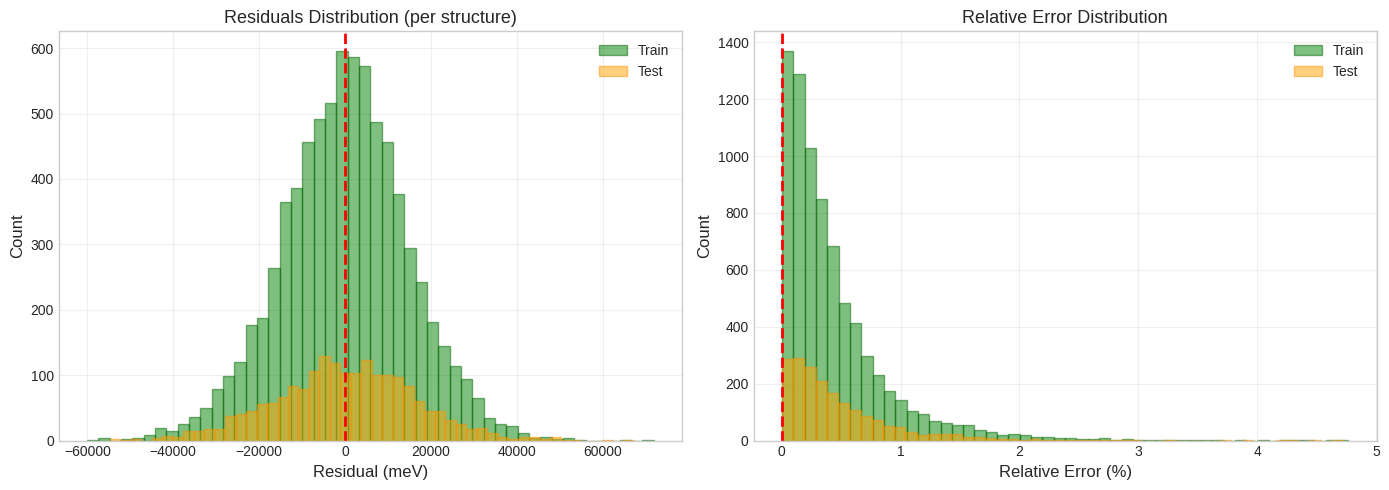

Saved: comparison_results/error_analysis.png

ERROR SUMMARY

Train Set (per structure):
  RMSE:       14.83 eV/structure
  MAE:        11.59 eV/structure
  Max error:  71.82 eV/structure
  R²:         0.999936

Train Set (per atom):
  RMSE:       25.5151 meV/atom
  MAE:        18.4504 meV/atom
  Max error:  170.0147 meV/atom

Train Set (relative error):
  Mean:       0.4374 %
  Max:        4.7689 %

Test Set (per structure):
  RMSE:       16.54 eV/structure
  MAE:        13.03 eV/structure
  Max error:  67.20 eV/structure
  R²:         0.999922

Test Set (per atom):
  RMSE:       28.1424 meV/atom
  MAE:        20.6468 meV/atom
  Max error:  172.2509 meV/atom

Test Set (relative error):
  Mean:       0.4847 %
  Max:        4.7232 %


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals histogram (per structure)
ax = axes[0]
train_res = results_list['train_predictions']['residuals'] * 1000
test_res = results_list['test_predictions']['residuals'] * 1000
ax.hist(train_res, bins=50, alpha=0.5, label='Train', color='green', edgecolor='darkgreen')
ax.hist(test_res, bins=50, alpha=0.5, label='Test', color='orange', edgecolor='darkorange')
ax.axvline(x=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Residual (meV)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Residuals Distribution (per structure)', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

# Relative error histogram
ax = axes[1]
train_rel = results_list['train_predictions']['rel_errors']
test_rel = results_list['test_predictions']['rel_errors']
ax.hist(train_rel, bins=50, alpha=0.5, label='Train', color='green', edgecolor='darkgreen')
ax.hist(test_rel, bins=50, alpha=0.5, label='Test', color='orange', edgecolor='darkorange')
ax.axvline(x=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Relative Error (%)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Relative Error Distribution', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'error_analysis.png', dpi=150)
plt.show()
print(f"Saved: {COMPARISON_DIR / 'error_analysis.png'}")

# Print summary statistics
train_m = results_list['train_metrics']
test_m = results_list['test_metrics']
train_rel_errors = results_list['train_predictions']['rel_errors']
test_rel_errors = results_list['test_predictions']['rel_errors']

print("\n" + "="*60)
print("ERROR SUMMARY")
print("="*60)
print("\nTrain Set (per structure):")
print(f"  RMSE:       {train_m['rmse']:.2f} eV/structure")
print(f"  MAE:        {train_m['mae']:.2f} eV/structure")
print(f"  Max error:  {train_m['max_error']:.2f} eV/structure")
print(f"  R²:         {train_m['r2']:.6f}")

print("\nTrain Set (per atom):")
print(f"  RMSE:       {train_m['rmse_per_atom']*1000:.4f} meV/atom")
print(f"  MAE:        {train_m['mae_per_atom']*1000:.4f} meV/atom")
print(f"  Max error:  {train_m['max_error_per_atom']*1000:.4f} meV/atom")

print("\nTrain Set (relative error):")
print(f"  Mean:       {train_m['mean_rel_error_percent']:.4f} %")
print(f"  Max:        {np.max(train_rel_errors):.4f} %")

print("\nTest Set (per structure):")
print(f"  RMSE:       {test_m['rmse']:.2f} eV/structure")
print(f"  MAE:        {test_m['mae']:.2f} eV/structure")
print(f"  Max error:  {test_m['max_error']:.2f} eV/structure")
print(f"  R²:         {test_m['r2']:.6f}")

print("\nTest Set (per atom):")
print(f"  RMSE:       {test_m['rmse_per_atom']*1000:.4f} meV/atom")
print(f"  MAE:        {test_m['mae_per_atom']*1000:.4f} meV/atom")
print(f"  Max error:  {test_m['max_error_per_atom']*1000:.4f} meV/atom")

print("\nTest Set (relative error):")
print(f"  Mean:       {test_m['mean_rel_error_percent']:.4f} %")
print(f"  Max:        {np.max(test_rel_errors):.4f} %")
print("="*60)

## ECI Analysis

Print ECIs with correct element mapping using `orbit.site_bases[j].site_space` and `orbit.bit_combos`

In [7]:
def print_ecis(subspace, coefs, only_nonzero=True):
    """Print ECIs with correct element mapping.
    
    Note: smol uses indicator basis where N species need only N-1 basis functions.
    The last species in each site_space has no explicit ECI (it's the reference).
    
    Args:
        subspace: ClusterSubspace object
        coefs: ECI coefficients array
        only_nonzero: If True, only print non-zero ECIs
    """
    orbit_ids = subspace.function_orbit_ids
    
    # Collect ECIs by type
    point_ecis = []  # (species, coef, orbit_id, reference_species)
    pair_ecis = []   # (sp1, sp2, distance, coef, orbit_id)
    triplet_ecis = []
    
    for i, coef in enumerate(coefs):
        if only_nonzero and abs(coef) < 1e-10:
            continue
            
        orbit_id = orbit_ids[i]
        
        if orbit_id == 0:
            print(f"[{i:4d}] Constant term: {coef:.6f} eV")
            continue
        
        orbit = subspace.orbits[orbit_id - 1]
        size = len(orbit.base_cluster)
        func_idx = i - orbit.bit_id
        bit_combo = orbit.bit_combos[func_idx][0]  # representative ordering
        
        # Get species from site_bases using function_array
        # bit_combo[j] is the index into the basis functions, not directly species
        species = []
        ref_species = []  # reference species (last one, no explicit ECI)
        for j in range(size):
            basis = orbit.site_bases[j]
            sp_list = list(basis.site_space.keys())
            func_array = basis.function_array
            func_idx_j = bit_combo[j]
            
            # Find which species this function is an indicator for
            # function_array[func_idx] has 1 at the species position
            indicator_row = func_array[func_idx_j]
            sp_idx = np.argmax(indicator_row)
            species.append(str(sp_list[sp_idx]))
            ref_species.append(str(sp_list[-1]))  # last species is reference
        
        if size == 1:
            point_ecis.append((species[0], coef, orbit_id, ref_species[0]))
        elif size == 2:
            dist = orbit.base_cluster.diameter
            pair_ecis.append((species[0], species[1], dist, coef, orbit_id))
        else:
            triplet_ecis.append((species, coef, orbit_id))
    
    # Print explanation
    print("\n" + "="*70)
    print("NOTE: smol uses indicator basis - each ECI is relative to a reference")
    print("  O/F sites: F is reference (no explicit ECI)")
    print("  Metal sites: Ni is reference (no explicit ECI)")
    print("="*70)
    
    # Print Point ECIs
    print("\n" + "="*60)
    print("POINT ECIs (cluster size = 1)")
    print("="*60)
    for sp, coef, oid, ref in sorted(point_ecis, key=lambda x: x[0]):
        print(f"  {sp:4s} (vs {ref}): {coef:12.6f} eV  (orbit {oid})")
    
    # Print Pair ECIs grouped by distance
    print("\n" + "="*60)
    print("PAIR ECIs (cluster size = 2)")
    print("="*60)
    pair_ecis_sorted = sorted(pair_ecis, key=lambda x: (x[2], x[0], x[1]))
    current_dist = None
    for sp1, sp2, dist, coef, oid in pair_ecis_sorted:
        if current_dist != dist:
            current_dist = dist
            print(f"\n  Distance: {dist:.4f} Å")
        print(f"    {sp1:4s}-{sp2:4s}: {coef:12.6f} eV  (orbit {oid})")
    
    # Print Triplet ECIs
    if triplet_ecis:
        print("\n" + "="*60)
        print("TRIPLET ECIs (cluster size = 3)")
        print("="*60)
        for species, coef, oid in triplet_ecis:
            sp_str = '-'.join(species)
            print(f"  {sp_str}: {coef:12.6f} eV  (orbit {oid})")
    
    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"  Total ECIs: {len(coefs)}")
    print(f"  Non-zero ECIs: {np.sum(np.abs(coefs) > 1e-10)}")
    print(f"  Point terms: {len(point_ecis)}")
    print(f"  Pair terms: {len(pair_ecis)}")
    print(f"  Triplet terms: {len(triplet_ecis)}")

# Load and print ECIs
subspace = results_list['subspace']
ecis = results_list['ecis']

print_ecis(subspace, ecis, only_nonzero=True)

[   0] Constant term: -40.536959 eV

NOTE: smol uses indicator basis - each ECI is relative to a reference
  O/F sites: F is reference (no explicit ECI)
  Metal sites: Ni is reference (no explicit ECI)

POINT ECIs (cluster size = 1)
  Al   (vs Ni):   -11.318412 eV  (orbit 2)
  Al   (vs Ni):    -9.828616 eV  (orbit 3)
  Co   (vs Ni):   -16.064104 eV  (orbit 2)
  Co   (vs Ni):    -8.250282 eV  (orbit 3)
  Cr   (vs Ni):   -52.279727 eV  (orbit 2)
  Cr   (vs Ni):   -20.649824 eV  (orbit 3)
  Cu   (vs Ni):   -11.066884 eV  (orbit 2)
  Cu   (vs Ni):    -4.484508 eV  (orbit 3)
  Fe   (vs Ni):   -30.211362 eV  (orbit 2)
  Fe   (vs Ni):   -18.586181 eV  (orbit 3)
  Li   (vs Ni):    34.594346 eV  (orbit 2)
  Li   (vs Ni):    19.275202 eV  (orbit 3)
  O    (vs F):  -160.678715 eV  (orbit 1)

PAIR ECIs (cluster size = 2)

  Distance: 1.9118 Å
    O   -Al  :   -29.687591 eV  (orbit 4)
    O   -Co  :   -18.965025 eV  (orbit 4)
    O   -Cr  :   -16.925064 eV  (orbit 4)
    O   -Cu  :    -0.560768 eV 

In [8]:
def get_eci_dataframes(subspace, coefs):
    """Extract ECIs into DataFrames for visualization.
    
    Note: smol indicator basis means:
    - O/F sites: O has explicit ECI, F is reference (ECI=0)
    - Metal sites: Li,Al,Cr,Fe,Co,Cu have explicit ECIs, Ni is reference (ECI=0)
    
    Returns:
        point_df: DataFrame with point ECIs
        pair_df: DataFrame with pair ECIs  
    """
    orbit_ids = subspace.function_orbit_ids
    
    point_data = []
    pair_data = []
    
    for i, coef in enumerate(coefs):
        orbit_id = orbit_ids[i]
        if orbit_id == 0:
            continue
            
        orbit = subspace.orbits[orbit_id - 1]
        size = len(orbit.base_cluster)
        func_idx = i - orbit.bit_id
        bit_combo = orbit.bit_combos[func_idx][0]
        
        species = []
        for j in range(size):
            basis = orbit.site_bases[j]
            sp_list = list(basis.site_space.keys())
            func_array = basis.function_array
            func_idx_j = bit_combo[j]
            indicator_row = func_array[func_idx_j]
            sp_idx = np.argmax(indicator_row)
            species.append(str(sp_list[sp_idx]))
        
        if size == 1:
            point_data.append({'species': species[0], 'eci': coef, 'orbit_id': orbit_id})
        elif size == 2:
            dist = orbit.base_cluster.diameter
            pair_data.append({
                'species1': species[0], 
                'species2': species[1],
                'pair': f"{species[0]}-{species[1]}",
                'distance': dist,
                'eci': coef,
                'orbit_id': orbit_id
            })
    
    point_df = pd.DataFrame(point_data)
    pair_df = pd.DataFrame(pair_data)
    
    return point_df, pair_df

# Get DataFrames
point_df, pair_df = get_eci_dataframes(subspace, ecis)

# Add reference species (F for anion, Ni for metal) with ECI=0
# This helps visualization show all species
print("="*70)
print("NOTE: Indicator basis reference species (implicit ECI=0):")
print("  - F (oxygen vacancy): reference for O/F sites")
print("  - Ni: reference for metal sites")
print("="*70)

# Aggregate Point ECIs by species (sum over orbits)
point_agg = point_df.groupby('species')['eci'].agg(['sum', 'mean', 'count']).reset_index()
point_agg.columns = ['species', 'eci_sum', 'eci_mean', 'n_orbits']

# Add reference species with ECI=0 for completeness
ref_species = [{'species': 'F', 'eci_sum': 0.0, 'eci_mean': 0.0, 'n_orbits': 0},
               {'species': 'Ni', 'eci_sum': 0.0, 'eci_mean': 0.0, 'n_orbits': 0}]
for ref in ref_species:
    if ref['species'] not in point_agg['species'].values:
        point_agg = pd.concat([point_agg, pd.DataFrame([ref])], ignore_index=True)

print("\nPoint ECIs aggregated by species:")
display(point_agg.sort_values('species'))

# Aggregate Pair ECIs by species pair and distance
pair_agg = pair_df.groupby(['species1', 'species2', 'distance'])['eci'].agg(['sum', 'mean', 'count']).reset_index()
pair_agg.columns = ['species1', 'species2', 'distance', 'eci_sum', 'eci_mean', 'n_funcs']
print("\nPair ECIs (non-zero only):")
display(pair_agg[pair_agg['eci_sum'].abs() > 1e-6].sort_values(['distance', 'species1', 'species2']))

NOTE: Indicator basis reference species (implicit ECI=0):
  - F (oxygen vacancy): reference for O/F sites
  - Ni: reference for metal sites

Point ECIs aggregated by species:


,species,eci_sum,eci_mean,n_orbits
0,Al,-21.147029,-10.573514,2
1,Co,-24.314386,-12.157193,2
2,Cr,-72.929551,-36.464776,2
3,Cu,-15.551392,-7.775696,2
7,F,0.000000,0.000000,0
4,Fe,-48.797542,-24.398771,2
5,Li,53.869548,26.934774,2
8,Ni,0.000000,0.000000,0
6,O,-160.678715,-160.678715,1



Pair ECIs (non-zero only):


,species1,species2,distance,eci_sum,eci_mean,n_funcs
171,O,Al,1.911809,-29.687591,-29.687591,1
181,O,Co,1.911809,-18.965025,-18.965025,1
191,O,Cr,1.911809,-16.925064,-16.925064,1
201,O,Cu,1.911809,-0.560768,-0.560768,1
211,O,Fe,1.911809,-14.494378,-14.494378,1
...,...,...,...,...,...,...
190,O,Co,5.606859,3.350067,3.350067,1
200,O,Cr,5.606859,0.880096,0.880096,1
210,O,Cu,5.606859,5.790821,5.790821,1
220,O,Fe,5.606859,1.973018,1.973018,1


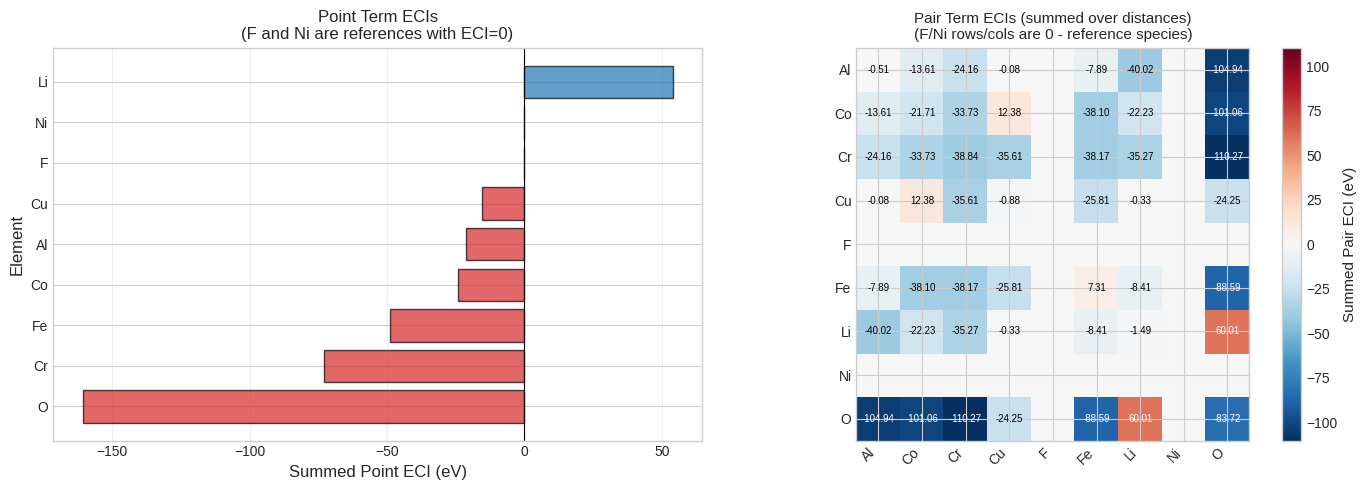

Saved: comparison_results/eci_analysis.png


In [9]:
# Visualization: Point ECIs bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Point ECIs
ax = axes[0]
point_sorted = point_agg.sort_values('eci_sum')
colors = ['tab:gray' if v == 0 else ('tab:red' if v < 0 else 'tab:blue') 
          for v in point_sorted['eci_sum']]
bars = ax.barh(point_sorted['species'], point_sorted['eci_sum'], color=colors, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Summed Point ECI (eV)', fontsize=12)
ax.set_ylabel('Element', fontsize=12)
ax.set_title('Point Term ECIs\n(F and Ni are references with ECI=0)', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')

# Pair ECIs heatmap - aggregate by species pair (sum over distances)
ax = axes[1]

# Get unique species (include F and Ni)
all_species = sorted(set(pair_df['species1'].tolist() + pair_df['species2'].tolist() + ['F', 'Ni']))
n_sp = len(all_species)
sp_idx = {sp: i for i, sp in enumerate(all_species)}

# Build matrix
pair_matrix = np.zeros((n_sp, n_sp))
for _, row in pair_df.iterrows():
    i, j = sp_idx[row['species1']], sp_idx[row['species2']]
    pair_matrix[i, j] += row['eci']

# Make symmetric for visualization
pair_matrix_sym = pair_matrix + pair_matrix.T
np.fill_diagonal(pair_matrix_sym, np.diag(pair_matrix))

vmax = np.abs(pair_matrix_sym).max()
if vmax < 1e-6:
    vmax = 1
im = ax.imshow(pair_matrix_sym, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='equal')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Summed Pair ECI (eV)', fontsize=11)

ax.set_xticks(range(n_sp))
ax.set_yticks(range(n_sp))
ax.set_xticklabels(all_species, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(all_species, fontsize=10)
ax.set_title('Pair Term ECIs (summed over distances)\n(F/Ni rows/cols are 0 - reference species)', fontsize=11)

# Add value annotations
for i in range(n_sp):
    for j in range(n_sp):
        val = pair_matrix_sym[i, j]
        if abs(val) > 1e-3:
            color = 'white' if abs(val) > vmax * 0.5 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=7)

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'eci_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {COMPARISON_DIR / 'eci_analysis.png'}")

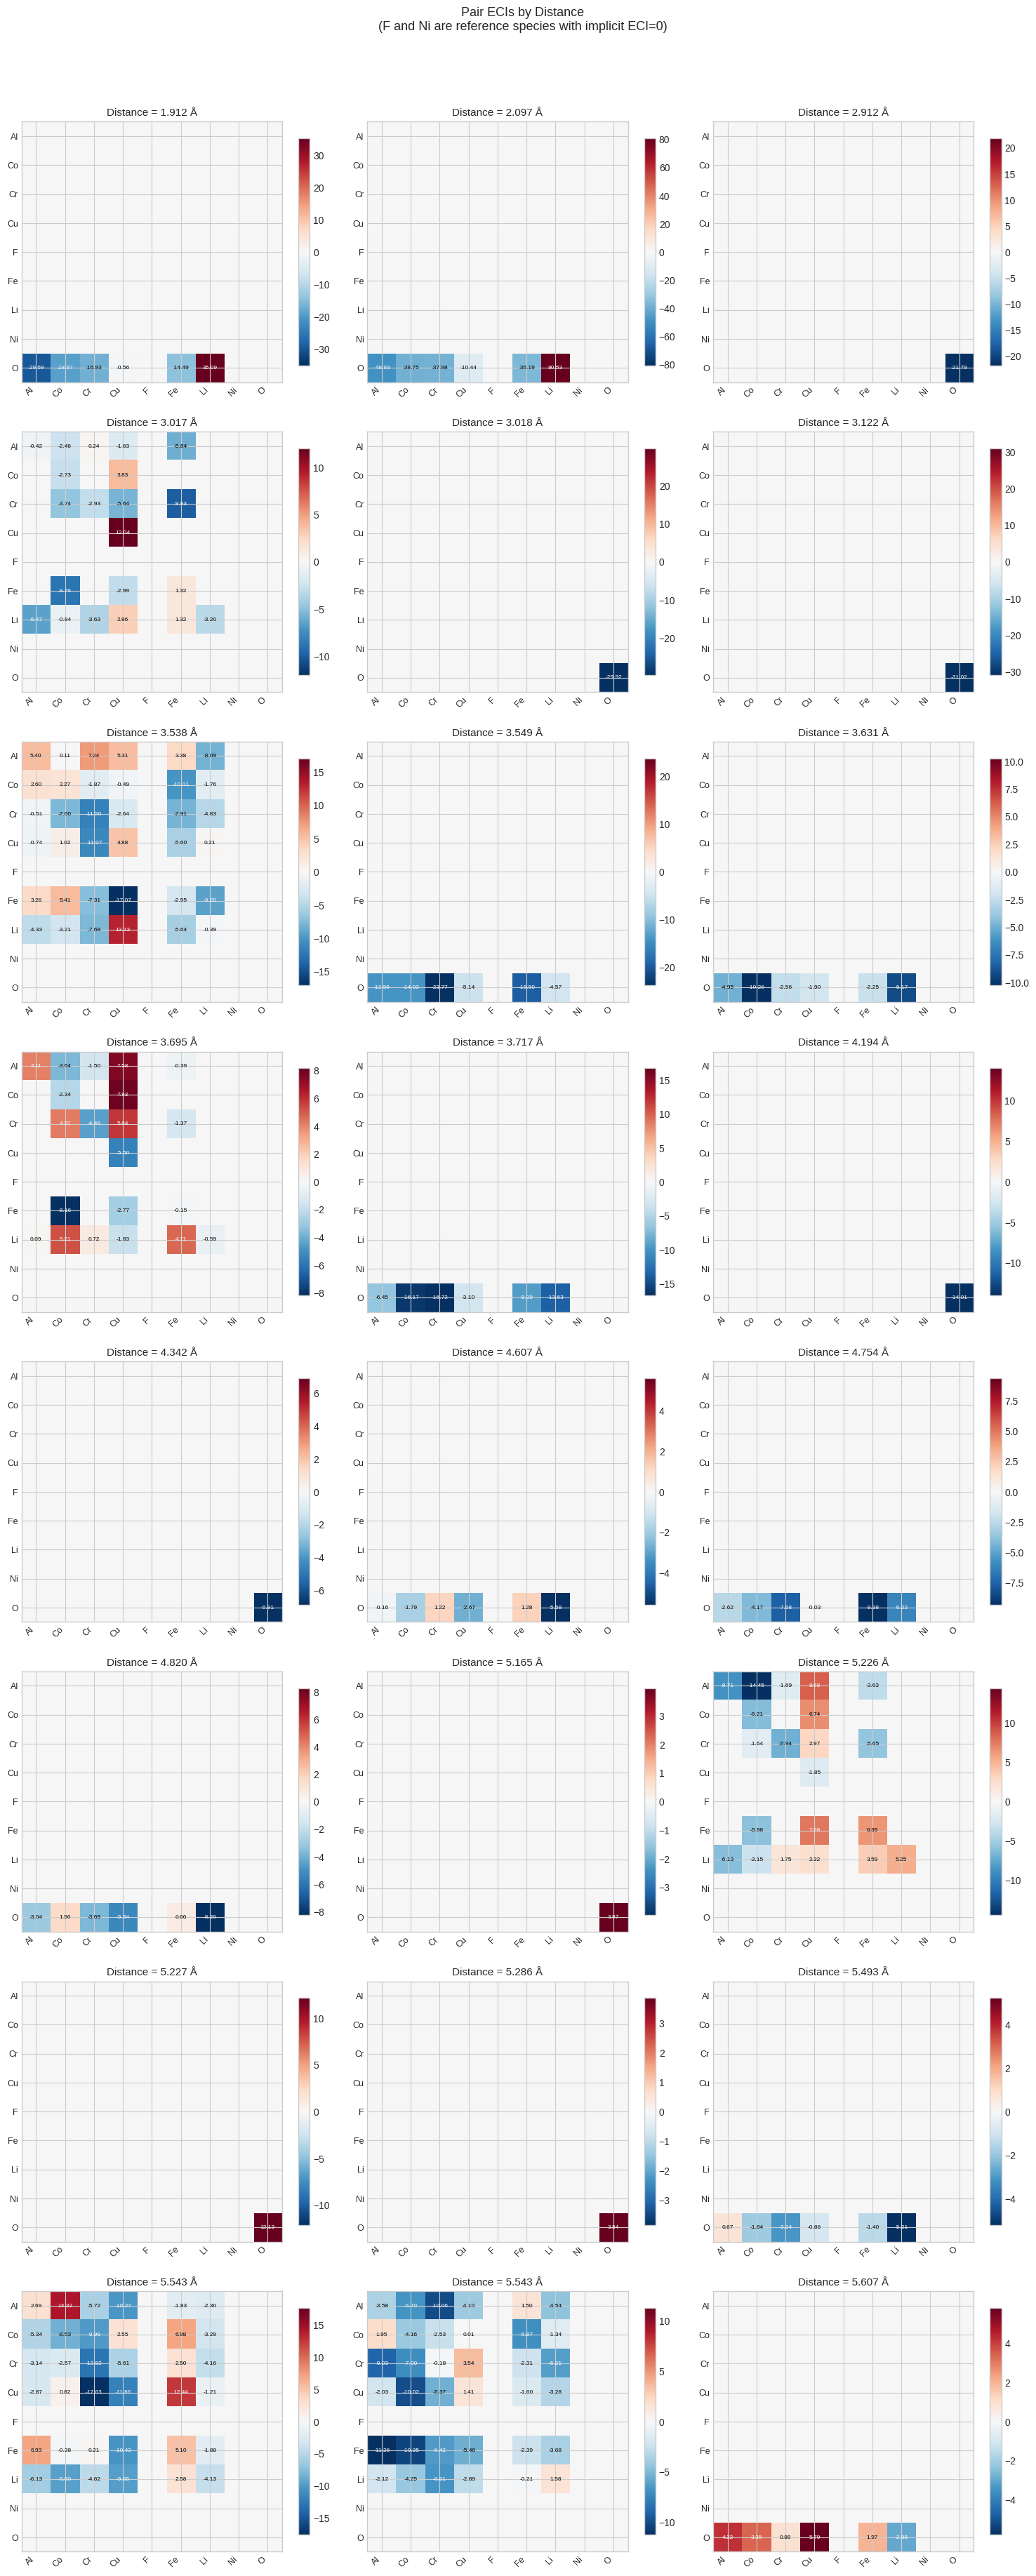

Saved: comparison_results/eci_pairs_by_distance.png


In [10]:
# Pair ECIs by distance - separate heatmaps
distances = sorted(pair_df['distance'].unique())
n_dist = len(distances)

# Include F and Ni in species list
all_species = sorted(set(pair_df['species1'].tolist() + pair_df['species2'].tolist() + ['F', 'Ni']))
n_sp = len(all_species)
sp_idx = {sp: i for i, sp in enumerate(all_species)}

if n_dist > 0:
    n_cols = min(3, n_dist)
    n_rows = (n_dist + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4.5*n_rows))
    if n_dist == 1:
        axes = np.array([[axes]])
    axes = np.atleast_2d(axes)
    
    for idx, dist in enumerate(distances):
        row, col = idx // n_cols, idx % n_cols
        ax = axes[row, col]
        
        # Filter by distance
        dist_df = pair_df[pair_df['distance'] == dist]
        
        # Build matrix for this distance
        pair_matrix = np.zeros((n_sp, n_sp))
        for _, r in dist_df.iterrows():
            i, j = sp_idx[r['species1']], sp_idx[r['species2']]
            pair_matrix[i, j] += r['eci']
        
        vmax = np.abs(pair_matrix).max()
        if vmax < 1e-6:
            vmax = 1
        im = ax.imshow(pair_matrix, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='equal')
        plt.colorbar(im, ax=ax, shrink=0.8)
        
        ax.set_xticks(range(n_sp))
        ax.set_yticks(range(n_sp))
        ax.set_xticklabels(all_species, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(all_species, fontsize=9)
        ax.set_title(f'Distance = {dist:.3f} Å', fontsize=11)
        
        # Add annotations
        for i in range(n_sp):
            for j in range(n_sp):
                val = pair_matrix[i, j]
                if abs(val) > 1e-3:
                    color = 'white' if abs(val) > vmax * 0.5 else 'black'
                    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=6)
    
    # Hide empty subplots
    for idx in range(n_dist, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle('Pair ECIs by Distance\n(F and Ni are reference species with implicit ECI=0)', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.savefig(COMPARISON_DIR / 'eci_pairs_by_distance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {COMPARISON_DIR / 'eci_pairs_by_distance.png'}")

## Spinel Site-Specific ECI Analysis

Separate ECIs by crystallographic site:
- **A site (tetrahedral, 8a)**: multiplicity = 8, coords ~ (0, 0, 0)
- **B site (octahedral, 16d)**: multiplicity = 16, coords ~ (0.375, 0.875, 0.125)
- **Anion site (32e)**: multiplicity = 32, O/F (oxygen vacancy)

In [11]:
def get_site_specific_ecis(subspace, coefs):
    """Extract ECIs separated by Spinel site type (A site, B site, Anion site).
    
    Spinel structure:
    - A site (tetrahedral, 8a): multiplicity = 8
    - B site (octahedral, 16d): multiplicity = 16  
    - Anion site (32e): multiplicity = 32
    
    Returns:
        site_info: dict with orbit info
        point_by_site: DataFrame with point ECIs by site
    """
    orbit_ids = subspace.function_orbit_ids
    
    # First, identify site types for each point orbit
    site_type_map = {}  # orbit_id -> site_type
    
    for orbit in subspace.orbits:
        if len(orbit.base_cluster) == 1:
            sp_list = [str(s) for s in orbit.site_bases[0].site_space.keys()]
            mult = orbit.multiplicity
            
            if 'O' in sp_list or 'F' in sp_list:
                site_type = 'Anion (32e)'
            elif mult == 8:
                site_type = 'A site (8a, tetrahedral)'
            elif mult == 16:
                site_type = 'B site (16d, octahedral)'
            else:
                site_type = f'Metal (mult={mult})'
            
            site_type_map[orbit.id] = site_type
    
    # Extract point ECIs with site info
    point_data = []
    
    for i, coef in enumerate(coefs):
        orbit_id = orbit_ids[i]
        if orbit_id == 0:
            continue
            
        orbit = subspace.orbits[orbit_id - 1]
        size = len(orbit.base_cluster)
        
        if size != 1:
            continue
            
        func_idx = i - orbit.bit_id
        bit_combo = orbit.bit_combos[func_idx][0]
        
        basis = orbit.site_bases[0]
        sp_list = list(basis.site_space.keys())
        func_array = basis.function_array
        indicator_row = func_array[bit_combo[0]]
        sp_idx = np.argmax(indicator_row)
        species = str(sp_list[sp_idx])
        ref_species = str(sp_list[-1])
        
        site_type = site_type_map.get(orbit_id, 'Unknown')
        
        point_data.append({
            'species': species,
            'eci': coef,
            'orbit_id': orbit_id,
            'site_type': site_type,
            'multiplicity': orbit.multiplicity,
            'reference': ref_species
        })
    
    point_df = pd.DataFrame(point_data)
    
    return site_type_map, point_df

# Get site-specific ECIs
site_type_map, point_by_site = get_site_specific_ecis(subspace, ecis)

print("="*70)
print("POINT ECIs BY SPINEL SITE TYPE")
print("="*70)

# Display by site type
for site_type in point_by_site['site_type'].unique():
    site_df = point_by_site[point_by_site['site_type'] == site_type].copy()
    ref = site_df['reference'].iloc[0] if len(site_df) > 0 else 'N/A'
    mult = site_df['multiplicity'].iloc[0] if len(site_df) > 0 else 'N/A'
    
    print(f"\n{site_type} (multiplicity={mult}, reference={ref}):")
    print("-" * 50)
    
    for _, row in site_df.sort_values('species').iterrows():
        print(f"  {row['species']:4s}: {row['eci']:12.6f} eV")

# Create comparison table
print("\n" + "="*70)
print("COMPARISON TABLE: Point ECIs by Site")
print("="*70)

pivot_df = point_by_site.pivot_table(
    index='species', 
    columns='site_type', 
    values='eci',
    aggfunc='first'
).reset_index()

# Add reference rows with 0
metal_sites = [col for col in pivot_df.columns if 'site' in col.lower()]
if len(metal_sites) > 0:
    ni_row = {'species': 'Ni (ref)'}
    for col in metal_sites:
        ni_row[col] = 0.0
    pivot_df = pd.concat([pivot_df, pd.DataFrame([ni_row])], ignore_index=True)

if 'Anion (32e)' in pivot_df.columns:
    f_row = {'species': 'F (ref)', 'Anion (32e)': 0.0}
    pivot_df = pd.concat([pivot_df, pd.DataFrame([f_row])], ignore_index=True)

display(pivot_df.sort_values('species'))

POINT ECIs BY SPINEL SITE TYPE

Anion (32e) (multiplicity=32, reference=F):
--------------------------------------------------
  O   :  -160.678715 eV

B site (16d, octahedral) (multiplicity=16, reference=Ni):
--------------------------------------------------
  Al  :   -11.318412 eV
  Co  :   -16.064104 eV
  Cr  :   -52.279727 eV
  Cu  :   -11.066884 eV
  Fe  :   -30.211362 eV
  Li  :    34.594346 eV

A site (8a, tetrahedral) (multiplicity=8, reference=Ni):
--------------------------------------------------
  Al  :    -9.828616 eV
  Co  :    -8.250282 eV
  Cr  :   -20.649824 eV
  Cu  :    -4.484508 eV
  Fe  :   -18.586181 eV
  Li  :    19.275202 eV

COMPARISON TABLE: Point ECIs by Site


,species,"A site (8a, tetrahedral)",Anion (32e),"B site (16d, octahedral)"
0,Al,-9.828616,NaN,-11.318412
1,Co,-8.250282,NaN,-16.064104
2,Cr,-20.649824,NaN,-52.279727
3,Cu,-4.484508,NaN,-11.066884
8,F (ref),NaN,0.000000,NaN
4,Fe,-18.586181,NaN,-30.211362
5,Li,19.275202,NaN,34.594346
7,Ni (ref),0.000000,NaN,0.000000
6,O,NaN,-160.678715,NaN


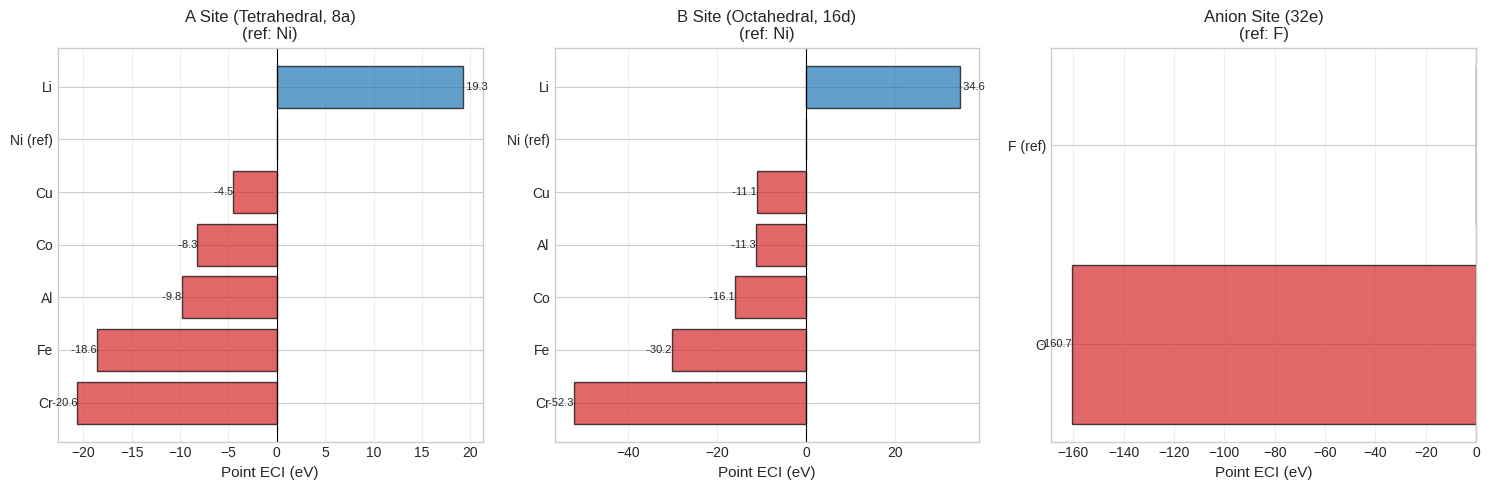

Saved: comparison_results/eci_by_site_type.png

SITE PREFERENCE ANALYSIS

Which site does each element prefer? (lower ECI = more stable)
Positive ΔE = prefers A site, Negative ΔE = prefers B site



,species,A site ECI,B site ECI,ΔE (A-B),Preferred site
0,Li,19.275202,34.594346,-15.319145,A site (tetrahedral)
1,Al,-9.828616,-11.318412,1.489796,B site (octahedral)
5,Cu,-4.484508,-11.066884,6.582376,B site (octahedral)
4,Co,-8.250282,-16.064104,7.813823,B site (octahedral)
3,Fe,-18.586181,-30.211362,11.625181,B site (octahedral)
2,Cr,-20.649824,-52.279727,31.629902,B site (octahedral)


In [12]:
# Visualization: Point ECIs by site type
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

site_types = ['A site (8a, tetrahedral)', 'B site (16d, octahedral)', 'Anion (32e)']
titles = ['A Site (Tetrahedral, 8a)', 'B Site (Octahedral, 16d)', 'Anion Site (32e)']

for ax, site_type, title in zip(axes, site_types, titles):
    site_df = point_by_site[point_by_site['site_type'] == site_type].copy()
    
    if len(site_df) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        continue
    
    ref = site_df['reference'].iloc[0]
    
    # Add reference species with ECI=0
    ref_row = pd.DataFrame([{'species': f'{ref} (ref)', 'eci': 0.0}])
    plot_df = pd.concat([site_df[['species', 'eci']], ref_row], ignore_index=True)
    plot_df = plot_df.sort_values('eci')
    
    colors = ['tab:gray' if '(ref)' in s else ('tab:red' if v < 0 else 'tab:blue') 
              for s, v in zip(plot_df['species'], plot_df['eci'])]
    
    bars = ax.barh(plot_df['species'], plot_df['eci'], color=colors, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Point ECI (eV)', fontsize=11)
    ax.set_title(f'{title}\n(ref: {ref})', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar, val in zip(bars, plot_df['eci']):
        if abs(val) > 0.1:
            ax.text(val, bar.get_y() + bar.get_height()/2, 
                   f' {val:.1f}', va='center', ha='left' if val > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'eci_by_site_type.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {COMPARISON_DIR / 'eci_by_site_type.png'}")

# Print site preference analysis
print("\n" + "="*70)
print("SITE PREFERENCE ANALYSIS")
print("="*70)
print("\nWhich site does each element prefer? (lower ECI = more stable)")
print("Positive ΔE = prefers A site, Negative ΔE = prefers B site\n")

a_site_df = point_by_site[point_by_site['site_type'] == 'A site (8a, tetrahedral)'].set_index('species')['eci']
b_site_df = point_by_site[point_by_site['site_type'] == 'B site (16d, octahedral)'].set_index('species')['eci']

preference_data = []
for sp in a_site_df.index:
    if sp in b_site_df.index:
        a_eci = a_site_df[sp]
        b_eci = b_site_df[sp]
        delta = a_eci - b_eci  # positive = prefers B site (lower ECI at B)
        preference = 'B site (octahedral)' if delta > 0 else 'A site (tetrahedral)'
        preference_data.append({
            'species': sp,
            'A site ECI': a_eci,
            'B site ECI': b_eci,
            'ΔE (A-B)': delta,
            'Preferred site': preference
        })

pref_df = pd.DataFrame(preference_data)
display(pref_df.sort_values('ΔE (A-B)'))

In [13]:
# Detailed Pair ECI analysis with A-A, A-B, B-B distinction

def get_pair_site_types(orbit):
    """Determine the site types for a pair orbit in spinel structure.
    
    Returns: tuple of (site1_type, site2_type) where type is 'A', 'B', or 'Anion'
    """
    def is_a_site(coord):
        # A site (8a): coords are multiples of 0.25 (0, 0.25, 0.5, 0.75)
        return all(abs(c % 0.25) < 0.02 or abs(c % 0.25 - 0.25) < 0.02 for c in coord)
    
    def is_b_site(coord):
        # B site (16d): coords have 0.125, 0.375, 0.625, 0.875
        return all(abs((c - 0.125) % 0.25) < 0.02 or abs((c - 0.125) % 0.25 - 0.25) < 0.02 for c in coord)
    
    site_types = []
    coords = orbit.base_cluster.frac_coords
    
    for j, basis in enumerate(orbit.site_bases):
        sp_list = [str(s) for s in basis.site_space.keys()]
        if 'O' in sp_list or 'F' in sp_list:
            site_types.append('Anion')
        else:
            coord = coords[j]
            if is_a_site(coord):
                site_types.append('A')
            elif is_b_site(coord):
                site_types.append('B')
            else:
                site_types.append('Metal')
    
    return tuple(site_types)

# Build detailed pair info
pair_orbit_info = []
for orbit in subspace.orbits:
    if len(orbit.base_cluster) == 2:
        site_types = get_pair_site_types(orbit)
        dist = orbit.base_cluster.diameter
        pair_type = '-'.join(site_types)
        
        pair_orbit_info.append({
            'orbit_id': orbit.id,
            'pair_type': pair_type,
            'distance': dist,
            'multiplicity': orbit.multiplicity,
            'n_functions': len(orbit.bit_combos)
        })

pair_orbit_df = pd.DataFrame(pair_orbit_info)

print("="*70)
print("PAIR ORBIT TYPES IN SPINEL STRUCTURE")
print("="*70)
print("\nA = tetrahedral (8a), B = octahedral (16d), Anion = O/F (32e)\n")
display(pair_orbit_df.sort_values(['pair_type', 'distance']))

# Summary by pair type
print("\n" + "="*70)
print("SUMMARY BY PAIR TYPE")
print("="*70)
summary = pair_orbit_df.groupby('pair_type').agg({
    'orbit_id': 'count',
    'distance': ['min', 'max'],
    'n_functions': 'sum'
}).reset_index()
summary.columns = ['Pair Type', 'N Orbits', 'Min Dist (Å)', 'Max Dist (Å)', 'Total Functions']
display(summary)

PAIR ORBIT TYPES IN SPINEL STRUCTURE

A = tetrahedral (8a), B = octahedral (16d), Anion = O/F (32e)



,orbit_id,pair_type,distance,multiplicity,n_functions
9,13,A-A,3.695050,16,21
0,4,Anion-A,1.911809,32,6
7,11,Anion-A,3.549496,96,6
13,17,Anion-A,4.607181,96,6
20,24,Anion-A,5.492724,96,6
23,27,Anion-A,5.606859,32,6
2,6,Anion-Anion,2.912020,48,1
4,8,Anion-Anion,3.017909,96,1
5,9,Anion-Anion,3.121971,48,1
11,15,Anion-Anion,4.193761,48,1



SUMMARY BY PAIR TYPE


,Pair Type,N Orbits,Min Dist (Å),Max Dist (Å),Total Functions
0,A-A,1,3.695050,3.695050,21
1,Anion-A,5,1.911809,5.606859,30
2,Anion-Anion,8,2.912020,5.286371,8
3,Anion-B,5,2.096881,4.820255,30
4,B-A,3,3.537741,5.542575,108
5,B-B,2,3.016995,5.225589,42


In [14]:
# Extract Pair ECIs with detailed site type info
def get_detailed_pair_ecis(subspace, coefs):
    """Extract pair ECIs with A/B site distinction."""
    orbit_ids = subspace.function_orbit_ids
    pair_data = []
    
    for i, coef in enumerate(coefs):
        orbit_id = orbit_ids[i]
        if orbit_id == 0:
            continue
            
        orbit = subspace.orbits[orbit_id - 1]
        if len(orbit.base_cluster) != 2:
            continue
            
        func_idx = i - orbit.bit_id
        bit_combo = orbit.bit_combos[func_idx][0]
        
        # Get species
        species = []
        for j in range(2):
            basis = orbit.site_bases[j]
            sp_list = list(basis.site_space.keys())
            func_array = basis.function_array
            indicator_row = func_array[bit_combo[j]]
            sp_idx = np.argmax(indicator_row)
            species.append(str(sp_list[sp_idx]))
        
        site_types = get_pair_site_types(orbit)
        pair_type = '-'.join(site_types)
        dist = orbit.base_cluster.diameter
        
        pair_data.append({
            'species1': species[0],
            'species2': species[1],
            'pair': f"{species[0]}-{species[1]}",
            'site_type': pair_type,
            'distance': dist,
            'eci': coef,
            'orbit_id': orbit_id
        })
    
    return pd.DataFrame(pair_data)

detailed_pair_df = get_detailed_pair_ecis(subspace, ecis)

# Show Metal-Metal pairs separated by A-A, A-B, B-B
print("="*70)
print("METAL-METAL PAIR ECIs BY SITE TYPE")
print("="*70)

for pair_type in ['A-A', 'B-A', 'B-B']:
    type_df = detailed_pair_df[detailed_pair_df['site_type'] == pair_type]
    if len(type_df) == 0:
        continue
    
    print(f"\n{pair_type} pairs:")
    print("-" * 50)
    
    # Aggregate by species pair and distance
    agg_df = type_df.groupby(['species1', 'species2', 'distance'])['eci'].sum().reset_index()
    agg_df = agg_df[agg_df['eci'].abs() > 1e-6]
    
    for dist in sorted(agg_df['distance'].unique()):
        dist_df = agg_df[agg_df['distance'] == dist]
        print(f"\n  Distance = {dist:.4f} Å:")
        for _, row in dist_df.sort_values(['species1', 'species2']).iterrows():
            print(f"    {row['species1']:4s}-{row['species2']:4s}: {row['eci']:10.4f} eV")

METAL-METAL PAIR ECIs BY SITE TYPE

A-A pairs:
--------------------------------------------------

  Distance = 3.6950 Å:
    Al  -Al  :     4.1130 eV
    Al  -Co  :    -3.6444 eV
    Al  -Cr  :    -1.5040 eV
    Al  -Cu  :     7.5795 eV
    Al  -Fe  :    -0.3876 eV
    Co  -Co  :    -2.3437 eV
    Co  -Cu  :     7.9264 eV
    Cr  -Co  :     4.2167 eV
    Cr  -Cr  :    -4.4602 eV
    Cr  -Cu  :     5.8392 eV
    Cr  -Fe  :    -1.3655 eV
    Cu  -Cu  :    -5.4989 eV
    Fe  -Co  :    -8.1578 eV
    Fe  -Cu  :    -2.7739 eV
    Fe  -Fe  :    -0.1524 eV
    Li  -Al  :     0.0914 eV
    Li  -Co  :     5.2144 eV
    Li  -Cr  :     0.7179 eV
    Li  -Cu  :    -1.8280 eV
    Li  -Fe  :     4.7072 eV
    Li  -Li  :    -0.5898 eV

B-A pairs:
--------------------------------------------------

  Distance = 3.5377 Å:
    Al  -Al  :     5.3981 eV
    Al  -Co  :     0.1084 eV
    Al  -Cr  :     7.2443 eV
    Al  -Cu  :     5.3055 eV
    Al  -Fe  :     3.3781 eV
    Al  -Li  :    -8.0884 eV
    Co  

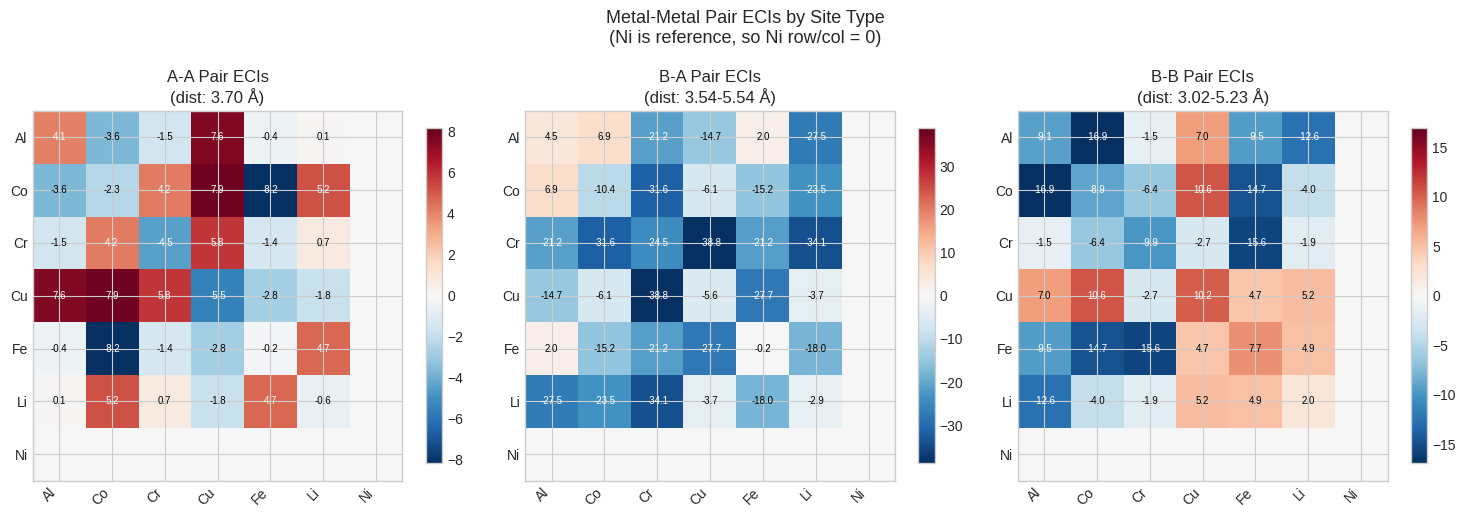

Saved: comparison_results/eci_metal_pairs_by_site.png


In [15]:
# Visualization: Pair ECIs heatmaps by site type (A-A, A-B, B-B)
metal_pair_types = ['A-A', 'B-A', 'B-B']
metal_species = ['Al', 'Co', 'Cr', 'Cu', 'Fe', 'Li', 'Ni']
n_metal = len(metal_species)
metal_idx = {sp: i for i, sp in enumerate(metal_species)}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, pair_type in zip(axes, metal_pair_types):
    type_df = detailed_pair_df[detailed_pair_df['site_type'] == pair_type]
    
    if len(type_df) == 0:
        ax.text(0.5, 0.5, f'No {pair_type} pairs', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{pair_type} Pair ECIs')
        continue
    
    # Sum over all distances
    pair_matrix = np.zeros((n_metal, n_metal))
    for _, row in type_df.iterrows():
        sp1, sp2 = row['species1'], row['species2']
        if sp1 in metal_idx and sp2 in metal_idx:
            i, j = metal_idx[sp1], metal_idx[sp2]
            pair_matrix[i, j] += row['eci']
    
    # Symmetrize
    pair_matrix_sym = pair_matrix + pair_matrix.T
    np.fill_diagonal(pair_matrix_sym, np.diag(pair_matrix))
    
    vmax = np.abs(pair_matrix_sym).max()
    if vmax < 1e-6:
        vmax = 1
    
    im = ax.imshow(pair_matrix_sym, cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='equal')
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    ax.set_xticks(range(n_metal))
    ax.set_yticks(range(n_metal))
    ax.set_xticklabels(metal_species, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(metal_species, fontsize=10)
    
    # Get distance range
    dists = type_df['distance'].unique()
    dist_range = f"{min(dists):.2f}-{max(dists):.2f}" if len(dists) > 1 else f"{dists[0]:.2f}"
    ax.set_title(f'{pair_type} Pair ECIs\n(dist: {dist_range} Å)', fontsize=12)
    
    # Add annotations
    for i in range(n_metal):
        for j in range(n_metal):
            val = pair_matrix_sym[i, j]
            if abs(val) > 0.01:
                color = 'white' if abs(val) > vmax * 0.5 else 'black'
                ax.text(j, i, f'{val:.1f}', ha='center', va='center', color=color, fontsize=7)

plt.suptitle('Metal-Metal Pair ECIs by Site Type\n(Ni is reference, so Ni row/col = 0)', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'eci_metal_pairs_by_site.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {COMPARISON_DIR / 'eci_metal_pairs_by_site.png'}")